In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [3]:
# importing json files

dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

df.head()

,preview,is_locked,tweet_id,sticky_comment,removal_source,link,author_flair_class,is_video_mp4,is_removed,title,...,link_metadata.twitter.parentTweet.quotedTweet.video.url,link_metadata.twitter.parentTweet.linkEmbed.image,link_metadata.twitter.parentTweet.linkEmbed.domain,link_metadata.twitter.parentTweet.linkEmbed.description,link_metadata.twitter.parentTweet.linkEmbed.title,link_metadata.twitter.parentTweet.linkEmbed.url,link_metadata.twitter.poll.options,link_metadata.twitter.poll.votes,link_metadata.twitter.poll.endTime,link_metadata.twitter.poll.winningPercentage
1,https://media.patriots.win/preview/199OBBRLnB.png,False,,0,,https://justthenews.com/politics-policy/elections/harris-top-three-surrogates-clinton-obama-and-biden-backfire-campaign,,False,False,"Harris' top surrogates Clinton, Obama and Biden backfire on campaign trail, boosting Trump\n",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://media.patriots.win/preview/199OBBRcds.png,False,1846481206574973063,0,,https://twitter.com/LegitTargets/status/1846481206574973063,,False,False,"President Trump: ""China thinks we are a very stupid country.""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://media.patriots.win/preview/199OBBRuDq.png,False,,0,,https://rumble.com/v5htmr5-springfield-woman-accuses-haitian-neighbors-of-cooking-her-cat....html,,False,False,Springfield Woman Accuses Haitian Neighbors of Cooking Her CAT.\r\n\r\n\r\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,https://media.patriots.win/preview/199OBBQWqP.png,False,,0,,https://media.scored.co/post/HuGmi3AXLuQz.png,,False,False,Times are tough for Tim Walz's friends under inflation.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,https://media.patriots.win/preview/199OBBRtpB.png,False,,0,,https://media.scored.co/post/kVoDIHDaM2Pn.jpeg,,False,False,"Greetings Patriots from Aruba! Miss all of you, just got internet, hope you are all holding down the Fort while I've been gone. 9 out of 10 people I've met are Trump Supporters, Amazing!!!",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# Replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# Format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = pd.to_datetime(df['created_date'])


# Fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.created_date.value_counts().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/4060232883.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


created_date
2024-07-21     31
2024-07-22    500
2024-07-23    615
2024-07-24    585
2024-07-25    631
             ... 
2024-10-13    607
2024-10-14    618
2024-10-15    617
2024-10-16    554
2024-10-17    269
Name: count, Length: 89, dtype: int64

In [5]:
# Unpack shortened domains
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import tldextract

common_shorts = [
    "adf.ly", "adfoc.us", "amzn.to", "atominik.com", "ay.gy", "b.link", "bhpho.to", "bit.ly", "bit.do", 
    "bn.gy", "branch.io", "buff.ly", "ceesty.com", "chollo.to", "cli.re", "cli.fm", "cutt.ly", "cutt.us", 
    "db.tt", "f.ls", "fa.by", "fb.me", "flip.it", "fumacrom.com", "git.io", "geni.us", "goo.gl", "gns.io", 
    "hmm.rs", "ht.ly", "hyperurl.co", "ity.im", "intamema.com", "is.gd", "j.gs", "j.mp", "kutt.it", "ldn.im", 
    "linklyhq.com", "microify.com", "mzl.la", "nmc.sg", "nowlinks.net", "ow.ly", "prf.hn", "plu.sh", "q.gs", 
    "qr.ae", "qr.net", "rebrand.ly", "rb.gy", "rlu.ru", "rotf.lol", "s.coop", "s.id", "sh.st", "soo.gd", 
    "shortcm.xyz", "short.gy", "shortcm.xyz", "shorturl.at", "smu.sg", "smq.tc", "snip.ly", "snipr.com", 
    "snipurl.com", "snurl.com", "split.to", "surl.li", "t.co", "t.ly", "t2m.io", "tiny.cc", "tiny.pl", 
    "tinyium.com", "tinyurl.com", "tiny.one", "tny.im", "tny.sh", "tr.im", "trib.al", "u.to", "v.gd", 
    "virg.in", "vzturl.com", "waa.ai", "washex.am", "x.co", "y2u.be", "yourwish.es", "zpr.io", "1url.com", 
    "2.gp", "3.ly", "4sq.com", "6url.com", "7.ly", "9.bb", "amp.gs", "atz.bz", "binged.it",
    "budurl.com", "cort.as", "decenturl.com", "dft.ba", "goo.gl", "inbound.org", "itsh.bo", "mcaf.ee",
    "n.pr", "nyti.ms", "on.fb.me", "prsm.tc", "redd.it", "tnw.to", "twt.fi", "u.nu", "virl.io", "wapo.st",
    "wp.me", "xrl.us",  "zurl.ws", "dlvr.it", 'msft.it', "lnkd.in ", 'spr.ly', 'rebelne.ws', 'scroll.in', 'ab.co',
    'hubs.li', 'bbc.in', 'nature.ly', 'cbsn.ws' , 'brnw.ch', 'youtu.be'
                ]

# Set up a Requests session with retries
session = requests.Session()
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'referer': 'https://www.google.com/'
}

headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        'referer':'https://google.com',
        'DNT':'1'
    }

# session.headers.update(headers)
retries = Retry(total=4, backoff_factor=1, status_forcelist=[502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

def check_connection(host='http://www.google.com'):
    try:
        session.get(host, timeout=1)
        return True
    except (requests.ConnectionError, requests.Timeout):
        return False

def wait_for_connection(interval=30, max_attempts=10):
    attempts = 0
    while not check_connection() and attempts < max_attempts:
        time.sleep(interval)
        attempts += 1
    return attempts < max_attempts

def resolve_url_head(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = requests.head(short_url, allow_redirects=True, timeout=1)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    
def resolve_url_get(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(short_url, allow_redirects=True, timeout=5)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(url=shortend_url, allow_redirects=True, timeout=1)        
   
    except requests.RequestException:
        return None    
    
df['domain'] = df['domain'].apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix if x != 'self_post' else 'self_post')
short_mask = df['domain'].isin(common_shorts)
df.loc[short_mask, 'domain'] = df.loc[short_mask, 'link'].apply(lambda x: resolve_url_get(x)).apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix)

In [6]:
# The top 10 most-shared domains on The Ronald's landing page
df.domain.value_counts(normalize=True).head(10)

domain
twitter.com             0.360606
scored.co               0.274715
patriots.win            0.143721
self_post               0.035456
thegatewaypundit.com    0.020928
youtube.com             0.018132
videy.co                0.010755
breitbart.com           0.009460
rumble.com              0.008878
zerohedge.com           0.007621
Name: proportion, dtype: float64

In [7]:
# Drop posts from 2024-07-21
df = df[df['created_date'] != '2024-07-21']

# Keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

df.groupby('created_date')['score_up'].min().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/960602510.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)


created_date
2024-07-22    42
2024-07-23    67
2024-07-24    56
2024-07-25    57
2024-07-26    49
              ..
2024-10-13    38
2024-10-14    49
2024-10-15    44
2024-10-16    34
2024-10-17    20
Name: score_up, Length: 88, dtype: int64

In [8]:
df.groupby('created_date')['score_up'].min().sort_index()

created_date
2024-07-22    42
2024-07-23    67
2024-07-24    56
2024-07-25    57
2024-07-26    49
              ..
2024-10-13    38
2024-10-14    49
2024-10-15    44
2024-10-16    34
2024-10-17    20
Name: score_up, Length: 88, dtype: int64

In [9]:
# Extract twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# Top twitter handles mentioned
df.value_counts('twitter_handle', ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/3006735851.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['twitter_handle'].fillna(np.nan, inplace=True)


twitter_handle
elonmusk         581
behizytweets     535
endwokeness      446
libsoftiktok     340
trumpwarroom     281
bennyjohnson     229
nicksortor       196
collinrugg       190
leadingreport    185
immeme0          185
Name: count, dtype: int64

In [10]:
df.created

0       2024-07-22 21:37:08.297000-04:00
1       2024-07-22 14:07:56.522000-04:00
2       2024-07-22 02:27:55.264000-04:00
3       2024-07-22 13:41:37.980000-04:00
4       2024-07-22 01:18:06.352000-04:00
                      ...               
43764   2024-10-17 11:21:03.589000-04:00
43765   2024-10-17 11:13:41.751000-04:00
43766   2024-10-17 11:43:46.715000-04:00
43767   2024-10-17 11:24:36.130000-04:00
43768   2024-10-17 11:14:19.186000-04:00
Name: created, Length: 43769, dtype: datetime64[ns, US/Eastern]

In [11]:
# A function that returns the top posts in interactive format
    
def top_posts_lastNdays(num, Ndays, save_table=False):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)
    top_posts = df[df.created_date >= start_date].nlargest(num,'score_up')
    top_posts['post_link'] = "https://patriots.win/p/" + top_posts['uuid']
    top_posts['title'] = top_posts.apply(lambda row: f'<a href="{row["post_link"]}">{row["title"]}</a>', axis=1)
    top_posts = top_posts[['title', 
                           'score_up', 
                           'comments', 
                           'author'
                           ]]
    
    
    top_posts = top_posts.reset_index().drop(columns='index')
    top_posts.index = np.arange(1, len(top_posts)+1)

    if save_table:
        html_content = top_posts.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
        
        with open(f'viz/most_popular_posts_in_the_last_day(s).html', "w") as html_file:
            html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable({{
                        pageLength: 25  // Set the number of entries to display per page
                    }});
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
                                         
    return top_posts


top_posts_lastNdays(num=20, Ndays=1, save_table=True)

,title,score_up,comments,author
1,"<a href=""https://patriots.win/p/199OFj0KpM"">After Fox Interview, Kamala Calls McDonald's To Ask If Her Old Job Still Available.</a>",1075,30,forth2win
2,"<a href=""https://patriots.win/p/199OFj0KpQ"">Kamala Harris Full Interview by Bret Baier on Fox News [26:43]</a>",1027,322,old_school_maga
3,"<a href=""https://patriots.win/p/199OFj0sWe"">Same energy</a>",835,36,POTUS_DonnieJ
4,"<a href=""https://patriots.win/p/199OFj0boG"">Know your toast levels </a>",813,41,awookienookie
5,"<a href=""https://patriots.win/p/199OFj1yin"">ELON MUSK TO HOLD FIRST RALLY IN FOLSOM, PA TOMORROW </a>",694,70,I-am-Orlando
6,"<a href=""https://patriots.win/p/199OFj1i8f"">Great job by Bret Baier in his Interview with Lyin’ Kamala Harris. She has a massive and irredeemable case of TRUMP DERANGEMENT SYNDROME</a>",692,43,no_comment
7,"<a href=""https://patriots.win/p/199OFj1A2c"">Daaayyyuumm, JD Vance! 🔥🔥🔥</a>",609,43,I-am-Orlando
8,"<a href=""https://patriots.win/p/199OFj0srM"">Rent Free</a>",571,29,Meanderthal
9,"<a href=""https://patriots.win/p/199OFk8j9E"">Baier: More than 70% of Americans say the country is on the wrong track. If you're turning the page, you've been in office for 3.5 years\n\nKamala: ""And Donald Trump has been running for office.""\n\nBaier: ""But you've been the person holding the office."" WTF WAS THAT?</a>",553,46,icehole3
10,"<a href=""https://patriots.win/p/199OFj0szY"">Roseanne Barr: Kamala is likely firing her whole staff after this Fox News interview. My god it was even better than I hoped! </a>",526,9,I-am-Orlando


In [12]:
def top_authors_lastNdays(num, Ndays):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)

    return df[df.created_date >=  start_date].author.value_counts().head(num)

top_authors_lastNdays(num=10, Ndays=1)

author
rdvs34283           14
icehole3            12
I-am-Orlando        10
Tcrussell            9
kinbergfan           9
grannylovestrump     6
CounterStrike        5
wstml555             5
blue5707             5
MythArcana           4
Name: count, dtype: int64

In [13]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 
stopwords.extend(["ago", 'old'])

import contractions
import emoji
import re



def clean_it_all_up (text, extra_stops):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [15]:
def ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())

    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [16]:
# Function of returning top ngrams from the past 24 hours

def ngram_generator_24hrs(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [17]:
dataframe = df
num = 2
top_n = 50
extra_stops=['trump']

top_50_bigrams_24hours = ngram_generator_24hrs(dataframe= dataframe, num=num, top_n=top_n, extra_stops=extra_stops )
top_50_bigrams_24hours

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/2951235605.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())


(kamala, harris)       51
(bret, baier)          34
(fox, news)            12
(joe, biden)           11
(jd, vance)            10
(elon, musk)           10
(harris, campaign)      9
(biden, harris)         9
(tim, walz)             9
(interview, kamala)     9
(baier, interview)      8
(baier, say)            8
(news, interview)       7
(town, hall)            7
(fox, interview)        7
(black, man)            6
(liz, cheney)           6
(harris, interview)     5
(election, day)         5
(kamala, campaign)      5
(north, carolina)       5
(kari, lake)            5
(united, states)        5
(american, people)      5
(say, kamala)           5
(violent, crime)        5
(kamala, interview)     5
(win, election)         5
(vote, harris)          4
(vote, kamala)          4
(matthew, metro)        4
(student, matthew)      4
(walz, student)         4
(crime, datum)          4
(illegal, alien)        4
(2, 1)                  4
(homeless, veteran)     4
(tucker, carlson)       4
(ted, cruz) 

In [18]:
top_50_bigrams_24hours_df = pd.DataFrame(top_50_bigrams_24hours).reset_index()

top_50_bigrams_24hours_df.index = np.arange(1, len(top_50_bigrams_24hours_df)+1)

top_50_bigrams_24hours_df.rename(columns={"index":'bigrams', 'count':'frequncy'}, inplace=True)

top_50_bigrams_24hours_df

,bigrams,frequncy
1,"(kamala, harris)",51
2,"(bret, baier)",34
3,"(fox, news)",12
4,"(joe, biden)",11
5,"(jd, vance)",10
6,"(elon, musk)",10
7,"(harris, campaign)",9
8,"(biden, harris)",9
9,"(tim, walz)",9
10,"(interview, kamala)",9


In [19]:
def save_interactive_table(dataframe, save_filename):
    html_content = dataframe.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
    with open(f'viz/{save_filename}.html', "w") as html_file:
         html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable({{
                        pageLength: 25  // Set the number of entries to display per page
                    }});
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
         
         return html_content

In [20]:
html_content = save_interactive_table(top_50_bigrams_24hours_df, 'top_bigrams_24hrs_table')

html_content

'<table border="1" class="dataframe table table-striped table-hover" id="my_table">\n  <thead>\n    <tr style="text-align: center;">\n      <th></th>\n      <th>bigrams</th>\n      <th>frequncy</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1</th>\n      <td>(kamala, harris)</td>\n      <td>51</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>(bret, baier)</td>\n      <td>34</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>(fox, news)</td>\n      <td>12</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>(joe, biden)</td>\n      <td>11</td>\n    </tr>\n    <tr>\n      <th>5</th>\n      <td>(jd, vance)</td>\n      <td>10</td>\n    </tr>\n    <tr>\n      <th>6</th>\n      <td>(elon, musk)</td>\n      <td>10</td>\n    </tr>\n    <tr>\n      <th>7</th>\n      <td>(harris, campaign)</td>\n      <td>9</td>\n    </tr>\n    <tr>\n      <th>8</th>\n      <td>(biden, harris)</td>\n      <td>9</td>\n    </tr>\n    <tr>\n      <th>9</th>\n      <td>(tim, walz)</td>\n    

In [21]:
# A function of returning top ngrams from the past 7 days

def ngram_generator_7days(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [22]:
# A function to return a wordcloud chart covering a specific period of dates
from wordcloud import WordCloud

def ngram_cloud(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    ngram = ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_stern').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [23]:
f"{datetime.datetime.now():%Y-%m-%d %H:%M}"


'2024-10-17 11:29'

In [24]:
# A function to return a wordcloud chart covering ONLY the past 24 hours

def ngram_24hrs_cloud(dataframe, num, save_viz, extra_stops, set_title=False, top_n=None):
    ngram = ngram_generator_24hrs(dataframe, num, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, 
               interpolation='nearest',
               aspect="auto"
               )
    
    if set_title:
        plt.title(f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M} (UTC)",
                fontsize=20,
                pad=10,
                style= "italic",
                loc='center'
                )
    plt.axis('off')
    plt.tight_layout()

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/2951235605.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())


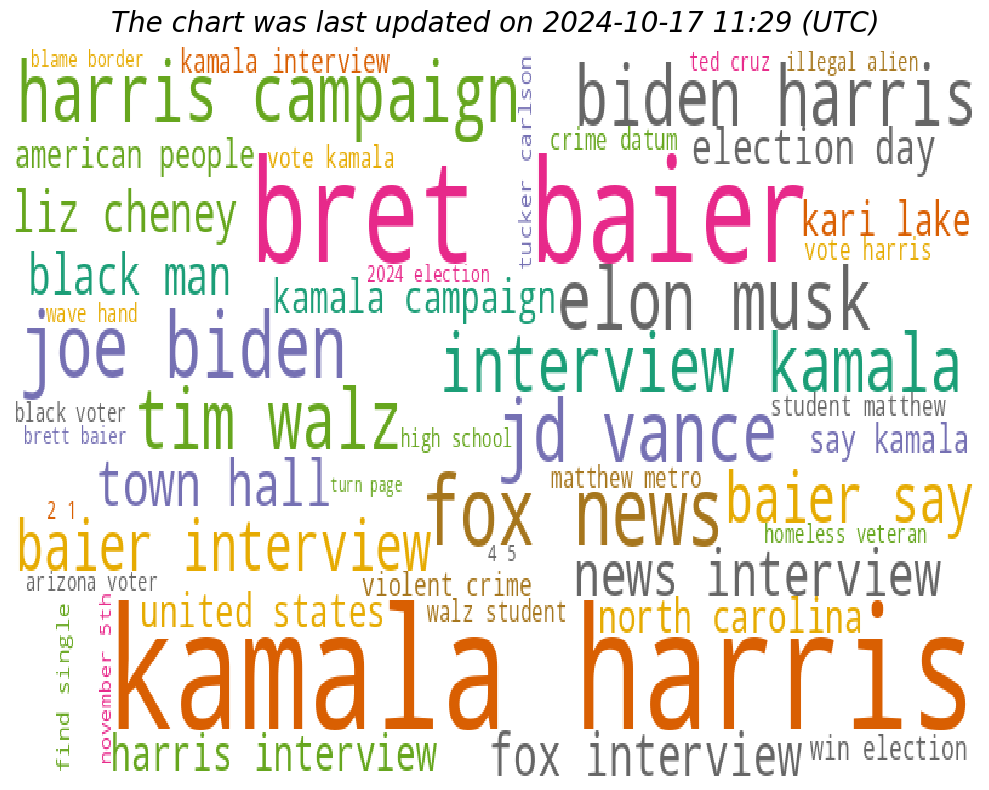

In [25]:
# creating and saving the top 50 bigrams from the last 24 hours
dataframe = df
num = 2
top_n = 50
save_viz = 'bigrams_wordcloud_24hrs'
extra_stops=['trump']
set_title=True
ngram_24hrs_cloud(dataframe = dataframe, num=num, top_n=top_n, save_viz=save_viz, set_title=set_title, extra_stops=extra_stops)



In [26]:
# A function to return a wordcloud chart covering ONLY the past 7 days

def ngram_7days_cloud(dataframe, num, save_viz, extra_stops, top_n=None):
    ngram = ngram_generator_7days(dataframe, num, extra_stops, top_n=None)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {top_n} bigrams in the last 7 days",
              fontsize=20,
              pad=25,
              )

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [27]:
# A summary table of authors based on a given date
def top_acounts(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_authors = dataframe[dataframe['created_date'].isin(date_list)]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = dataframe.groupby('author').comments.sum()
    upvotes_total = dataframe.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={
                                        'author': 'top_authors',
                                        'count' : 'posts',
                                        'comments': 'accumulated_comments',
                                        'score_up': 'accumulated_upvotes'
                                        })
    top_authors = top_authors.sort_values('posts', ascending=False).head(top_n)
    return  top_authors

In [28]:
# This function returns the most posted domains from a specific period of time

def top_domains(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_urls = dataframe[dataframe['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [29]:
# This function returns the most posted domains from the last 7 days

def top_domains_7days(dataframe, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    top_urls = dataframe[dataframe['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [30]:
# Popular Twitter accounts on The Ronald

def top_xitter(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    xiter_accounts = dataframe[(dataframe.link.str.contains('twitter.com'))& (dataframe['created_date'].isin(date_list))]
    top_xitter = xiter_accounts['link'].str.split('/').str[3].str.lower().value_counts(normalize=False, dropna=False).head(top_n)
    return top_xitter

In [31]:
# A date-based n-gram generator
# useful for making time-series charts 

def new_ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    # Filter dates
    date_list = date_selection(start_date, end_date)
    
    # Filter and process data
    filtered_df = dataframe[dataframe.created_date.isin(date_list)]
    filtered_df['cleaned_title'] = filtered_df['title'].apply(lambda x: clean_it_all_up(x, extra_stops))

    
    ngrams_with_dates = []
    
    for index, row in filtered_df.iterrows():
        tokens = row['cleaned_title'].split()
        if num ==1:
            unigrams_list = list(tokens)
            for unigram in unigrams_list:
                ngrams_with_dates.append((unigram, row['created_date']))
        elif num == 2:
            bigrams_list = list(bigrams(tokens))
            for bigram in bigrams_list:
                ngrams_with_dates.append((bigram, row['created_date']))
        elif num == 3:
            trigrams_list = list(trigrams(tokens))
            for trigram in trigrams_list:
                ngrams_with_dates.append((trigram, row['created_date']))
        else:
            raise ValueError('Invalid number. Must choose between 2 or 3.')
    
    ngram_df = pd.DataFrame(ngrams_with_dates, columns=['ngram', 'date']).head(top_n)
    return ngram_df


In [32]:
def ngram_time_series(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    plt.figure(figsize=(10, 8))


    top_ngram_plot = sns.lineplot(data=top_ngram_pivot)

    plt.xlabel('')
    plt.ylabel('Mention count')
    plt.title(f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}')

    plt.xticks(rotation=45) 
    plt.grid(True)

    plt.legend(title='Top Bigrams', bbox_to_anchor=(1.3, 1), loc='upper right')
    
    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [33]:
# create interactive charts with Plotly

import plotly.graph_objs as go

def ngram_time_series_interactive(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):
    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))

    fig.update_layout(
        width=1400,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis_title='Date',
        yaxis_title='Frequency',
        
        xaxis=dict(tickangle=45),
        legend_title_text='Top Bigrams'
    )

    if save_viz is not None:
        fig.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        fig.show()
    else:
        fig.show()

In [34]:
# This function would only cover the past n days

def ngram_time_last_n_days_interactive(dataframe, num, last_ndays, extra_stops, save_filename, top_n=None):
    end_date = pd.to_datetime(dataframe['created_date'].max())
    start_date = end_date - pd.Timedelta(days=last_ndays)
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    # Prepare the data for plotting
    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    y_max = top_ngram_pivot.values.max()
    y_range = [0, y_max * 1.1]

    fig = go.Figure()

    # Add traces for each n-gram
    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)
        ))

    fig.update_traces(line={'width': 5})

    layout = dict(
        width=1000,
        height=800,
        xaxis=dict(
            title='Date',
            tickangle=45
        ),
        yaxis=dict(
            title='Frequency',
            range=y_range
        ),
        legend_title=dict(
            text='<b>Popular Bigrams<br>',
            font=dict(
                family="Courier",
                color='firebrick',
                size=15
            )
        )
    )
    

    if set_title:
        layout['title'] = dict(
            text= f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M} (UTC)",
            font=dict(
                family="Arial",
                size=20
            ),
            pad=dict(t=20)
        )

    fig.update_layout(layout)

    if save_filename:
        fig.write_html(f"viz/{save_filename}.html")
    
    fig.show()

In [35]:
def ngram_time_last_7_days_interactive(dataframe, num, extra_stops, save_filename, set_title=False, top_n=None):
    end_date = pd.to_datetime(dataframe['created_date'].max())
    start_date = end_date - pd.Timedelta(days=7)
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    # Prepare the data for plotting
    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    y_max = top_ngram_pivot.values.max()
    y_range = [0, y_max * 1.1]

    fig = go.Figure()

    # Add traces for each n-gram
    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)
        ))

    fig.update_traces(line={'width': 5})

    layout = dict(
        width=1000,
        height=800,
        xaxis=dict(
            title='Date',
            tickangle=45
        ),
        yaxis=dict(
            title='Frequency',
            range=y_range
        ),
        legend_title=dict(
            text='<b>Popular Bigrams<br>',
            font=dict(
                family="Courier",
                color='firebrick',
                size=15
            )
        )
    )

    margin = dict(l=0,
                  r=0,
                  t=0,
                  b=10)

    if set_title:
        layout['title'] = dict(
            text= f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M} (UTC)",
            font=dict(
                family="Arial",
                size=20
            ),
            pad=dict(t=20)
        )

    fig.update_layout(layout, margin)

    if save_filename:
        fig.write_html(f"viz/{save_filename}.html")
    
    fig.show()

In [36]:
# create a separate dataframe that include only youtube-linked posts
youtube_df = df[df.domain=='youtube.com']

# a functiont that extract youtube ids from urls
def youtube_parser(url):
    # Regular expression to capture YouTube video IDs from various URL formats
    id_pattern = r'(?:https?:\/\/)?(?:[0-9A-Z-]+\.)?(?:youtube|youtu|youtube-nocookie)\.(?:com|be)\/(?:watch\?v=|watch\?.+&v=|embed\/|v\/|.+\?v=)?([^&=\n%\?]{11})'
    
    match = re.search(id_pattern, url)
    return match.group(1) if match else np.nan

# extract videos id 
youtube_df['youtube_id'] = youtube_df['link'].apply(youtube_parser)


/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/198214060.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_df['youtube_id'] = youtube_df['link'].apply(youtube_parser)


In [37]:
# This function returns the most posted domains from the last 7 days

def youtube_last_ndays(dataframe, ndays):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=ndays)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    dataframe = dataframe[dataframe['created_date'].isin(date_list)].sort_values('score_up')
    return dataframe


youtube_3days_df = youtube_last_ndays(youtube_df, 3)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_4597/2687004662.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dataframe = dataframe[dataframe['created_date'].isin(date_list)].sort_values('score_up')


In [38]:
import os
from dotenv import load_dotenv

def congfiure():
    load_dotenv()
    api_key = os.getenv('api_key')
    return api_key

In [39]:
import sys
sys.path.append("/Users/keenansmacbookairm3/Documents/GitHub/SearchTube")
#importa
from SearchTube import tube_meta

In [40]:
video_id = youtube_3days_df.youtube_id.to_list()
api_key = congfiure()

video_meta =  tube_meta(video_id, api_key)
video_meta_df = pd.DataFrame(video_meta)

Video metadata list_1 fetched
---------
Finished fetching ALL 1 chunks of video metadata


In [41]:
# A funciton to extract first paragraph from a longer chunck of text
def find_first_paragraph(text):
    first_paragraph = re.search(r'(.+?)(?:\n\s*\n|$)', text, re.DOTALL)
    return first_paragraph.group(1).strip() if first_paragraph else ''

In [42]:
youtube_3days_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 43492 to 43050
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          19 non-null     object                    
 1   uuid               19 non-null     object                    
 2   title              19 non-null     object                    
 3   content            19 non-null     object                    
 4   post_flair_text    19 non-null     object                    
 5   author             19 non-null     object                    
 6   author_flair_text  19 non-null     object                    
 7   created            19 non-null     datetime64[ns, US/Eastern]
 8   comments           19 non-null     int64                     
 9   score_up           19 non-null     int64                     
 10  preview            19 non-null     object                    
 11  link               

In [43]:
# run the function on the full description
video_meta_df['brief_desription'] = video_meta_df.full_description.apply(find_first_paragraph).str.replace('\n', ' ')

# merge the two youtube dataframes
youtube_3days_df = youtube_3days_df.merge(video_meta_df, left_on='youtube_id', right_on='video_id')

In [44]:
# rename publishedAt column and fix format
youtube_3days_df['publishedAt'] = pd.to_datetime(youtube_3days_df['publishedAt'])

youtube_3days_df['published_date_on_youtube']  = youtube_3days_df['publishedAt'].dt.date

In [45]:
# create a dataframe specifically for the html
display_df = youtube_3days_df[['full_title', 
                               'published_date_on_youtube',
                               'brief_desription', 
                               'channel_title', 
                               'link', 
                               'created_date',
                               'score_up',
                               'comments'
                               ]].sort_values('score_up', ascending=False)

# reset index 
display_df = display_df.reset_index(drop=True)
display_df.index +=1

# embed youtube to title text in the table
display_df['full_title']= display_df.apply(lambda row: f'<a href="{row["link"]}">{row["full_title"]}</a>', axis=1)

# drop link field
display_df = display_df.drop(columns = 'link')

# rename some column headers
display_df = display_df.rename(columns ={'full_title':'video title',
                                         'brief_desription': 'brief desription',
                                         'published_date_on_youtube': 'published date',
                                         "created_date": 'shared date (The Donald)',
                                         'score_up': 'upvote count (The Donald)',
                                         'comments' : 'comment count(The Donald)'
                                         })

display_df

,video title,published date,brief desription,channel_title,shared date (The Donald),upvote count (The Donald),comment count(The Donald)
1,"<a href=""https://www.youtube.com/watch?v=Fn_CCb_PohM"">LIVE: JD Vance hosts MAGA rally in Pennsylvania</a>",2024-10-16,"Republican Vice Presidential candidate JD Vance holds a rally in Williamsport, Pennsylvania.",The Times and The Sunday Times,2024-10-16,959,18
2,"<a href=""https://www.youtube.com/watch?v=X29F9ifPXyo"">LIVE: JD Vance Joining Moms for America Town Hall in Philly</a>",2024-10-16,"- 🇺🇸 Stay updated with breaking news, special reports, and LIVE COVERAGE on NTD: https://ept.ms/NTDlive_",NTD,2024-10-16,729,16
3,"<a href=""https://www.youtube.com/watch?v=tC7QY33UYpo"">LIVE REPLAY: President Trump Delivers Remarks in Atlanta, GA - 10/15/24</a>",2024-10-16,"President Donald J. Trump, 45th President of the United States of America, will deliver remarks in Atlanta, Georgia, on Tuesday, October 15, 2024, at 7:30PM EDT.",Right Side Broadcasting Network,2024-10-16,671,58
4,"<a href=""https://www.youtube.com/watch?v=kAtafpFHQG8"">LIVE REPLAY: President Trump Delivers Remarks at Town Hall in Oaks, PA - 10/14/24</a>",2024-10-15,"President Donald J. Trump, 45th President of the United States of America, will deliver remarks at a town hall in Oaks, Pennsylvania, on Monday, October 14, 2024, at 6:00 p.m. EDT.",Right Side Broadcasting Network,2024-10-14,582,160
5,"<a href=""https://www.youtube.com/watch?v=i2WQOpKiXg4"">Kamala's Team RAGE QUITS After SHE IMPLODES INTO ANGER AND YELLING In TRAINWRECK Fox News Interview!</a>",2024-10-16,👕Merch: https://gforemanbcp.com/ 🤙🏾 Patreon: https://www.patreon.com/blackconservativeperspective 👊Paypal: paypal.me/gforemanbcp 💸Cash App: $gforemanbcp 🏃‍♂️Follow me on Twitter: https://twitter.com/gforemanBCP @gforemanBCP 📷 Follow me on Instagram: https://www.instagram.com/gforemanbcp/ ⭐ Wooden American Star: https://bridgethegapshop.com/discount/GFOREMANBCP,Black Conservative Perspective,2024-10-17,100,3
6,"<a href=""https://www.youtube.com/watch?v=EEALcvDcKT4"">Smug Democrat PANICS When GOP Catches Him LYING In Real-Time About January 6th!!!</a>",2024-10-14,Smug Democrat PANICS When GOP Catches Him LYING In Real-Time About January 6th!!!,Preta Moraes,2024-10-14,88,1
7,"<a href=""https://www.youtube.com/watch?v=j329OKgWo20"">Adults attack 14-year-old girl who spoke out after losing race to a boy</a>",2024-10-10,"Ahnaleigh's story has now been heard millions of times after a clip from unDivided went viral. Now, adults are saying she's just a sore loser.",[un]Divided with Brandi Kruse,2024-10-14,78,3
8,"<a href=""https://youtu.be/G4l2UsZ0-s8?si=Yuzce7Zl3YLnWukd"">Young people should think twice about voting for a ticket with Kamala Harris on it!</a>",2020-10-07,Young people should think twice about voting for a ticket with Kamala Harris on it.,Donald J Trump,2024-10-17,69,1
9,"<a href=""https://www.youtube.com/watch?v=wgq0FtCOWag"">ELON AND ROCKETS!</a>",2024-10-13,President Donald Trump Praises Elon Musk's GROUNDBREAKING SpaceX rocket catch landing today.,Real America's Voice,2024-10-14,61,1
10,"<a href=""https://www.youtube.com/watch?v=XTcnAy36zH4"">Ana Kasparian admits it</a>",2024-10-15,Oh no,Memomorph,2024-10-15,60,5


In [46]:
youtube_html = display_df.to_html(render_links=True, 
                                        justify='center', 
                                        escape=False,
                                        classes='table table-striped table-hover', 
                                        table_id='my_table'
                                        )

with open(f'viz/youtube_videos_shared_onto_The_Donalds_last_3_days.html', "w") as youtube_html_file:
            youtube_html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable({{
                        pageLength: 25  // Set the number of entries to display per page
                    }});
                }} );
                </script>
                </head>
                <body>
                {youtube_html}
                </body>
                </html>
            """)


In [47]:
# Looking into claims of election fraud
election_keywords = ['election', 'vote', 'voting', 'ballot', 'poll']
election_df = df[df.title.str.contains("|".join(election_keywords), case=False, na=False)]

fraud_keywords = ['fraud', 'cheat', 'rig', 'steal', 'stolen', 'fake','tamper', 'scam', 'interfer']
fraud_df = df[(df.title.str.contains("|".join(fraud_keywords) , case=False, na=False)) & (df.title.str.contains("|".join(election_keywords) , case=False, na=False))]

fraud_counts = fraud_df.created_date.value_counts(dropna=False).sort_index()
election_counts = election_df.created_date.value_counts(dropna=False).sort_index()

# merge two series into a dataframe
result_df = pd.DataFrame([fraud_counts, election_counts]).T

# rename the column headers
result_df.columns = ['election fraud', 'election']

result_df

,election fraud,election
created_date,,
2024-07-22,8,42
2024-07-23,8,39
2024-07-24,3,48
2024-07-25,7,50
2024-07-26,11,49
...,...,...
2024-10-13,6,50
2024-10-14,8,45
2024-10-15,18,59


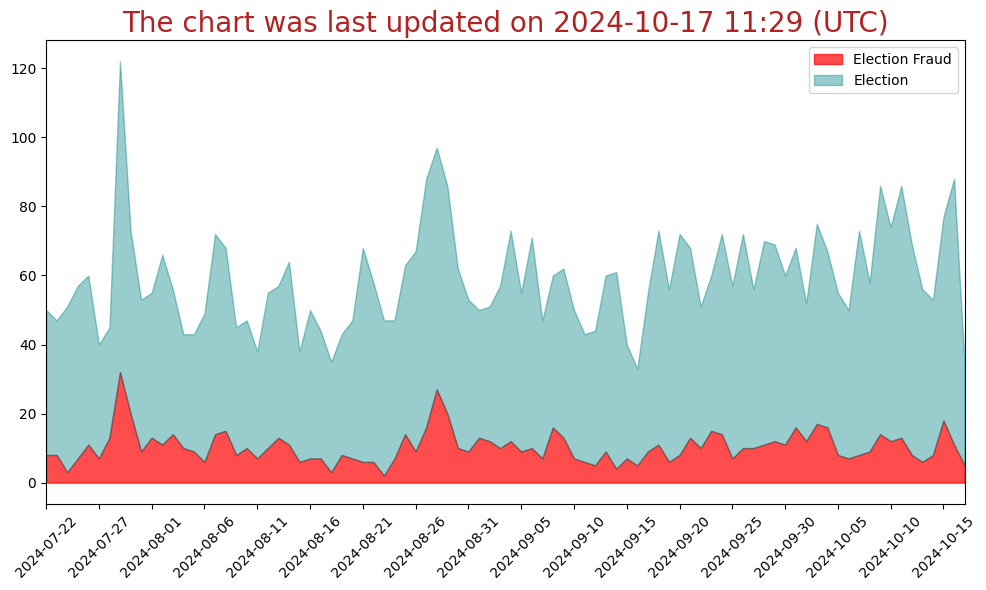

In [48]:
plt.figure(figsize=(10, 6))

plt.fill_between(result_df.index, result_df['election fraud'], color='red', alpha=0.7, label='Election Fraud')

plt.fill_between(result_df.index, 
                 result_df['election fraud'] + result_df['election'], 
                 result_df['election fraud'], 
                 color='teal', alpha=0.4, label='Election')

x_label_date_range = pd.date_range(fraud_df['created_date'].min(), 
                           fraud_df['created_date'].max(), 
                           freq='5D')


plt.xlim([fraud_df['created_date'].min(), fraud_df['created_date'].max()])

plt.xticks(ticks=x_label_date_range, 
           rotation=45)
plt.xlabel('')

# Updated title
election_fraud_filename = f"Posts mentioning election vs election fraud since {fraud_df['created_date'].min().date()}"

plt.legend(loc='upper right')
plt.title(label =f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M} (UTC)",
          fontdict = {"fontsize":20,
                      "color":'firebrick'
                      }
          )

plt.tight_layout()

# Save the figure
plt.savefig(f"viz/{election_fraud_filename}.jpeg", dpi=600)
plt.show()
